In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
import folium
import json

In [2]:
data = pd.read_csv('food-inspections.csv')
data.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,CHICAGO,IL,60606.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':...",NaN,NaN,NaN,NaN,NaN
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613.0,...,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",NaN,NaN,NaN,NaN,NaN
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,CHICAGO,IL,60618.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'...",NaN,NaN,NaN,NaN,NaN
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,CHICAGO,IL,60622.0,...,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,CHICAGO,IL,60608.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [3]:
loc= data[["Latitude","Longitude","AKA Name","Risk"]]
missing = loc[loc.isnull().any(axis = 1)]
data_removed = data.drop(missing.index)
data_removed = data_removed.reset_index()
data_removed["Risk"] = data_removed["Risk"].replace(to_replace =["Risk 3 (Low)", "Risk 2 (Medium)", "Risk 1 (High)","All"],  
                            value =[1,2,3,3]) 
data_removed.Risk = data_removed.Risk.astype(float)
data_removed["Risk"].value_counts()

3.0    139031
2.0     37402
1.0     16192
Name: Risk, dtype: int64

In [4]:
fac = (data['Facility Type'].value_counts())
print("The possible results for each facilites are the follwoing with the results given by:")
display(data['Results'].value_counts())

The possible results for each facilites are the follwoing with the results given by:


Pass                    105795
Fail                     37870
Pass w/ Conditions       27105
Out of Business          16844
No Entry                  6237
Not Ready                 1877
Business Not Located        68
Name: Results, dtype: int64

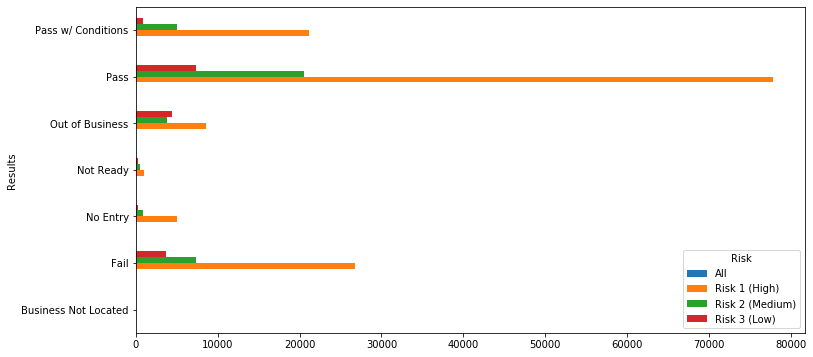

In [5]:
facility = data.groupby("Risk")
facility['Results'].value_counts().unstack(0).plot.barh(figsize=(12,6))
plt.show()

In [6]:
zip_data = data_removed.groupby("Zip")
mean_risk = zip_data.Risk.mean()
risk_map = pd.DataFrame(mean_risk)
risk_map.Risk = (risk_map.Risk.values).astype(int)
risk_map = risk_map.reset_index()


In [7]:
coord = [data_removed["Latitude"][0],data_removed["Longitude"][0]]
m= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)


In [9]:
def create_map(table,zips,add_text=""):
    chicago_geo = r'updated-file.json'
    # initiating a Folium map with longitude and latitude
    m = folium.Map(location = coord,tiles='Stamen Toner', zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = chicago_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.name',
        # first element contains location information, second element contains feature of interest
        columns = [zips],
        fill_color = 'RdYlGn',
        #legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across LA'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')

In [25]:
state_geo_path = r'chicago.geojson'
geo_json_data = json.load(open(state_geo_path))
m_usa = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(geo_json_data).add_to(m_usa)


In [34]:
def coloriage(zip_):
    for i in range(1,len(risk_map)):
        low_risk = risk_map.loc[risk_map['Zip'] == zip_, 'Risk'].values[0] == 1
        medium_risk = risk_map.loc[risk_map['Zip'] == zip_, 'Risk'].values[0] == 2
        high_risk = risk_map.loc[risk_map['Zip'] == zip_, 'Risk'].values[0] == 3
        if low_risk:
            return '#0000ff'
        if medium_risk:
            return '#00ff00'
        if high_risk:
            return '#ff0000'

In [49]:
results_map = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(
    geo_json_data,
    style_function=lambda features: {
        'fillColor': coloriage(features["properties"]["ZIP"]),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)

results_map

C:\Users\marco\Desktop\Python\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [46]:
m_usa = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=risk_map,
    columns=['Zip', 'Risk'],
    key_on='feature.properties.ZIP',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Risk given to restaurant'
).add_to(m_usa)
m_usa

In [56]:
geo_json_data


{'type': 'FeatureCollection',
 'features': [{'geometry': {'type': 'Polygon',
    'coordinates': [[[-87.67762151065274, 41.91775780106294],
      [-87.67746629571167, 41.91058209819497],
      [-87.67758604324135, 41.910472738554404],
      [-87.72633069402347, 41.909886697801646],
      [-87.72669587979634, 41.92188163427005],
      [-87.72707509896246, 41.9226450783149],
      [-87.7264407576935, 41.92265352753663],
      [-87.72673805446694, 41.92331017314154],
      [-87.72697869215132, 41.93179036266599],
      [-87.6781352871441, 41.93228468026097],
      [-87.67828661109851, 41.92920798102205],
      [-87.67786951423847, 41.92452988234949],
      [-87.67762151065274, 41.91775780106294]]]},
   'type': 'Feature',
   'id': 0,
   'properties': {'adjacent_zips': ['60639',
     '60641',
     '60657',
     '60618',
     '60622',
     '60614'],
    'ZIP': '60647',
    'adjacent_community_areas': ['20', '21', '22', '23', '24', '5', '7']}},
  {'geometry': {'type': 'Polygon',
    'coordinat